<a href="https://colab.research.google.com/github/prp20/tensorflow_learning/blob/main/practice_timeseries_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pwd

/content


In [23]:
!unzip /content/archive.zip -d /content/dataset

Archive:  /content/archive.zip
replace /content/dataset/DailyDelhiClimateTest.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/dataset/DailyDelhiClimateTrain.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [25]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [26]:
def load_data(path, col=None, verbose=False):
    df = pd.read_csv(path)
    if col is not None:
        df = df[col]
    if verbose:
        print(df.head())
    return df

train_data_path = "/content/dataset/DailyDelhiClimateTrain.csv"
test_data_path = "/content/dataset/DailyDelhiClimateTest.csv"
train_df = load_data(train_data_path, verbose=True)
test_df = load_data(test_data_path)

         date   meantemp   humidity  wind_speed  meanpressure
0  2013-01-01  10.000000  84.500000    0.000000   1015.666667
1  2013-01-02   7.400000  92.000000    2.980000   1017.800000
2  2013-01-03   7.166667  87.000000    4.633333   1018.666667
3  2013-01-04   8.666667  71.333333    1.233333   1017.166667
4  2013-01-05   6.000000  86.833333    3.700000   1016.500000


In [27]:
def clean_data(series):
    """Fills missing values. 
    
        Interpolate missing values with a linear approximation.
    """
    series_filled = series.interpolate(method='linear')
        
    return series_filled
        
    
def min_max_scale(dataframe):
    """ Applies MinMax Scaling
    
        Wrapper for sklearn's MinMaxScaler class.
    """
    mm = MinMaxScaler()
    return mm.fit_transform(dataframe)

def make_time_features(series):
    
    #convert series to datetimes
    datetimes = pd.DatetimeIndex(series)
    
    year = datetimes.year.values
    day = datetimes.day.values
    months = datetimes.month.values
    
    years = pd.Series(year, name='hours')
    dayofw = pd.Series(day, name='dayofw')
    month = pd.Series(months, name='months')
    
    return years, dayofw, month

years, day, month = make_time_features(train_df.date)
print("Hours")
print(years.head())
print("Day of Week")
print(day.tail())
print("Months")
print(month.tail())

Hours
0    2013
1    2013
2    2013
3    2013
4    2013
Name: hours, dtype: int64
Day of Week
1457    28
1458    29
1459    30
1460    31
1461     1
Name: dayofw, dtype: int64
Months
1457    12
1458    12
1459    12
1460    12
1461     1
Name: months, dtype: int64


In [34]:
def split_data(series, train_fraq):
    """Splits input series into train, val and test.
    
        Default to 1 year of test data.
    """
    #slice the last year of data for testing 1 year has 8760 hours
    train_val_data = series

    #make train and validation from the remaining
    train_size = int(len(train_val_data) * train_fraq)
    
    train_data = train_val_data[:train_size]
    val_data = train_val_data[train_size:]
    test_data = val_data
    return train_data, val_data, test_data


train_cleaned_df = clean_data(train_df)
print(train_cleaned_df.head())
#add hour and month features
years, day, months = make_time_features(train_cleaned_df.date)
multivar_df = pd.concat([train_cleaned_df.drop(['date'], axis=1), years, day, months], axis=1)
print(multivar_df.head())
#scale
multivar_df = min_max_scale(multivar_df)
print(multivar_df[:15])
train_multi, val_multi, test_multi = split_data(multivar_df, train_fraq=0.80)
print("Multivarate Datasets")
print(f"Train Data Shape: {train_multi.shape}")
print(f"Val Data Shape: {val_multi.shape}")
print(f"Test Data Shape: {test_multi.shape}")
print(f"Nulls In Train {np.any(np.isnan(train_multi))}")
print(f"Nulls In Validation {np.any(np.isnan(val_multi))}")
print(f"Nulls In Test {np.any(np.isnan(test_multi))}")

         date   meantemp   humidity  wind_speed  meanpressure
0  2013-01-01  10.000000  84.500000    0.000000   1015.666667
1  2013-01-02   7.400000  92.000000    2.980000   1017.800000
2  2013-01-03   7.166667  87.000000    4.633333   1018.666667
3  2013-01-04   8.666667  71.333333    1.233333   1017.166667
4  2013-01-05   6.000000  86.833333    3.700000   1016.500000
    meantemp   humidity  wind_speed  meanpressure  hours  dayofw  months
0  10.000000  84.500000    0.000000   1015.666667   2013       1       1
1   7.400000  92.000000    2.980000   1017.800000   2013       2       1
2   7.166667  87.000000    4.633333   1018.666667   2013       3       1
3   8.666667  71.333333    1.233333   1017.166667   2013       4       1
4   6.000000  86.833333    3.700000   1016.500000   2013       5       1
[[0.12227074 0.8209571  0.         0.13260331 0.         0.
  0.        ]
 [0.04279476 0.90759076 0.07058266 0.132881   0.         0.03333333
  0.        ]
 [0.0356623  0.84983498 0.10974262

In [31]:
def window_dataset(data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=False, expand_dims=False):
    window = n_steps + n_horizon
    if expand_dims:
        ds = tf.expand_dims(data, axis=-1)
        ds = tf.data.Dataset.from_tensor_slices(ds)
    else:
        ds = tf.data.Dataset.from_tensor_slices(data)
    ds = ds.window(window, shift=n_horizon, drop_remainder=True)
    ds = ds.flat_map(lambda x : x.batch(window))
    # ds = ds.shuffle(shuffle_buffer)    
    if multi_var:
        ds = ds.map(lambda x : (x[:-n_horizon], x[-n_horizon:, :1]))
    else:
        ds = ds.map(lambda x : (x[:-n_horizon], x[-n_horizon:]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

tf.random.set_seed(42)

n_steps = 10
n_horizon = 1
batch_size = 1
shuffle_buffer = 100


ds = window_dataset(train_multi, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=True)

print('Example sample shapes')
for idx,(x,y) in enumerate(ds):
    print("x = ", x.numpy().shape)
    print("y = ", y.numpy().shape)
    break

Example sample shapes
x =  (1, 10, 7)
y =  (1, 1, 1)


In [32]:
for idx,(x,y) in enumerate(ds):
  print(y.numpy()[0])

[[0.29694323]]
[[0.24454148]]
[[0.30058224]]
[[0.20887918]]
[[0.26637555]]
[[0.23944687]]
[[0.3209607]]
[[0.23944687]]
[[0.19868996]]
[[0.16157205]]
[[0.15895197]]
[[0.1069869]]
[[0.24454148]]
[[0.23944687]]
[[0.19104803]]
[[0.20378457]]
[[0.20960699]]
[[0.27001456]]
[[0.24836245]]
[[0.26637555]]
[[0.31179039]]
[[0.30567686]]
[[0.31441048]]
[[0.36681223]]
[[0.34934498]]
[[0.32478166]]
[[0.32605531]]
[[0.29344978]]
[[0.24454148]]
[[0.28820961]]
[[0.28275109]]
[[0.3018559]]
[[0.2852984]]
[[0.31441048]]
[[0.34643377]]
[[0.40247453]]
[[0.25764192]]
[[0.23435226]]
[[0.29344978]]
[[0.30131004]]
[[0.3580786]]
[[0.4279476]]
[[0.44323144]]
[[0.34934498]]
[[0.33187773]]
[[0.33242358]]
[[0.36244541]]
[[0.45240175]]
[[0.41048035]]
[[0.34643377]]
[[0.39737991]]
[[0.40756914]]
[[0.35458515]]
[[0.45469432]]
[[0.45414847]]
[[0.53275109]]
[[0.55531295]]
[[0.59388646]]
[[0.52401747]]
[[0.55021834]]
[[0.5349345]]
[[0.47379913]]
[[0.4992722]]
[[0.55531295]]
[[0.43813683]]
[[0.50946143]]
[[0.53275109]]
[[0

In [38]:
def build_dataset(n_steps, n_horizon, batch_size=32, shuffle_buffer=100, expand_dims=False, multi_var=False):
    tf.random.set_seed(23)
    
    if multi_var:
        data = load_data(train_data_path, col=['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure'])
        hours, day, months = make_time_features(data.date)
        data = pd.concat([data.drop(['date'], axis=1), years, day, months], axis=1)
    else:
        data = load_data(col=['meantemp'])
        
    data = clean_data(data)
    
    if multi_var:
        mm = MinMaxScaler()
        data = mm.fit_transform(data)
    
    train_data, val_data, test_data = split_data(data, train_fraq=0.8)
    
    train_ds = window_dataset(train_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    val_ds = window_dataset(val_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    test_ds = window_dataset(test_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    
    
    print(f"Prediction lookback (n_steps): {n_steps}")
    print(f"Prediction horizon (n_horizon): {n_horizon}")
    print(f"Batch Size: {batch_size}")
    print("Datasets:")
    print(train_ds.element_spec)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = build_dataset(n_steps=10, n_horizon=1, multi_var=True)

Prediction lookback (n_steps): 10
Prediction horizon (n_horizon): 1
Batch Size: 32
Datasets:
(TensorSpec(shape=(None, None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))


In [39]:
def get_params(multivar=False):
    lr = 3e-4
    n_steps=10
    n_horizon=1
    if multivar:
        n_features=7
    else:
        n_features=1
        
    return n_steps, n_horizon, n_features, lr

In [40]:
model_configs = dict()

def cfg_model_run(model, history, test_ds):
    return {"model": model, "history" : history, "test_ds": test_ds}


def run_model(model_name, model_func, model_configs, epochs):
    
    n_steps, n_horizon, n_features, lr = get_params(multivar=True)
    train_ds, val_ds, test_ds = build_dataset(n_steps=n_steps, n_horizon=n_horizon, multi_var=True)

    model = model_func(n_steps, n_horizon, n_features, lr=lr)

    model_hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

    model_configs[model_name] = cfg_model_run(model, model_hist, test_ds)
    return test_ds

In [41]:
def dnn_model(n_steps, n_horizon, n_features, lr):
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(n_steps, n_features)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name='dnn')
    
    loss=tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model


dnn = dnn_model(*get_params(multivar=True))
dnn.summary()

Model: "dnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 70)                0         
                                                                 
 dense (Dense)               (None, 128)               9088      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 25,729
Trainable params: 25,729
Non-trainable par

In [46]:
def cnn_model(n_steps, n_horizon, n_features, lr=3e-4):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(n_steps,n_features)),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name="CNN")
    
    loss= tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

cnn = cnn_model(*get_params(multivar=True))
cnn.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 8, 64)             1408      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4, 64)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 64)             12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0       

In [43]:
def lstm_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(72, activation='relu', input_shape=(n_steps, n_features), return_sequences=True),
        tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name='lstm')
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

lstm = lstm_model(*get_params(multivar=True))
lstm.summary()

Model: "lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 72)            23040     
                                                                 
 lstm_1 (LSTM)               (None, 48)                23232     
                                                                 
 flatten (Flatten)           (None, 48)                0         
                                                                 
 dropout (Dropout)           (None, 48)                0         
                                                                 
 dense (Dense)               (None, 128)               6272      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129    

In [47]:
def lstm_cnn_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(n_steps,n_features)),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.LSTM(72, activation='relu', return_sequences=True),
        tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name="lstm_cnn")
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

lstm_cnn = lstm_cnn_model(*get_params(multivar=True))
lstm_cnn.summary()

Model: "lstm_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 8, 64)             1408      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4, 64)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 64)             12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 1, 72)             39456     
                                                                 
 lstm_1 (LSTM)               (None, 48)                232

In [48]:
def lstm_cnn_skip_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
   
    inputs = tf.keras.layers.Input(shape=(n_steps,n_features), name='main')
    
    conv1 = tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu')(inputs)
    max_pool_1 = tf.keras.layers.MaxPooling1D(2)(conv1)
    conv2 = tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu')(max_pool_1)
    max_pool_2 = tf.keras.layers.MaxPooling1D(2)(conv2)
    lstm_1 = tf.keras.layers.LSTM(72, activation='relu', return_sequences=True)(max_pool_2)
    lstm_2 = tf.keras.layers.LSTM(48, activation='relu', return_sequences=False)(lstm_1)
    flatten = tf.keras.layers.Flatten()(lstm_2)
    
    skip_flatten = tf.keras.layers.Flatten()(inputs)

    concat = tf.keras.layers.Concatenate(axis=-1)([flatten, skip_flatten])
    drop_1 = tf.keras.layers.Dropout(0.3)(concat)
    dense_1 = tf.keras.layers.Dense(128, activation='relu')(drop_1)
    drop_2 = tf.keras.layers.Dropout(0.3)(dense_1)
    output = tf.keras.layers.Dense(n_horizon)(drop_2)
    
    model = tf.keras.Model(inputs=inputs, outputs=output, name='lstm_skip')
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

lstm_skip = lstm_cnn_skip_model(*get_params(multivar=True))
lstm_skip.summary()

Model: "lstm_skip"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 main (InputLayer)              [(None, 10, 7)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 8, 64)        1408        ['main[0][0]']                   
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 4, 64)        0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 2, 64)        12352       ['max_pooling1d[0][0]']          
                                                                                          

In [49]:
model_configs=dict()
run_model("dnn", dnn_model, model_configs, epochs=150)
run_model("cnn", cnn_model, model_configs, epochs=150)
run_model("lstm", lstm_model, model_configs, epochs=150)
run_model("lstm_cnn", lstm_cnn_model, model_configs, epochs=150)
run_model("lstm_skip", lstm_cnn_skip_model, model_configs, epochs=150)

Prediction lookback (n_steps): 10
Prediction horizon (n_horizon): 1
Batch Size: 32
Datasets:
(TensorSpec(shape=(None, None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))
Epoch 1/150
37/37 [==============================] - 7s 24ms/step - loss: 0.0819 - mae: 0.3211 - val_loss: 0.0252 - val_mae: 0.1999
Epoch 2/150
37/37 [==============================] - 0s 10ms/step - loss: 0.0218 - mae: 0.1679 - val_loss: 0.0049 - val_mae: 0.0799
Epoch 3/150
37/37 [==============================] - 0s 9ms/step - loss: 0.0136 - mae: 0.1318 - val_loss: 0.0037 - val_mae: 0.0691
Epoch 4/150
37/37 [==============================] - 0s 8ms/step - loss: 0.0107 - mae: 0.1182 - val_loss: 0.0041 - val_mae: 0.0730
Epoch 5/150
37/37 [==============================] - 0s 8ms/step - loss: 0.0115 - mae: 0.1223 - val_loss: 0.0083 - val_mae: 0.1087
Epoch 6/150
37/37 [==============================] - 0s 8ms/step - loss: 0.0091 - mae: 0.1072 - val_loss: 0.0050 - val_ma

Prediction lookback (n_steps): 10
Prediction horizon (n_horizon): 1
Batch Size: 32
Datasets:
(TensorSpec(shape=(None, None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))
Epoch 1/150
37/37 [==============================] - 8s 18ms/step - loss: 0.0444 - mae: 0.2449 - val_loss: 0.0108 - val_mae: 0.1249
Epoch 2/150
37/37 [==============================] - 0s 9ms/step - loss: 0.0172 - mae: 0.1465 - val_loss: 0.0047 - val_mae: 0.0757
Epoch 3/150
37/37 [==============================] - 0s 9ms/step - loss: 0.0135 - mae: 0.1316 - val_loss: 0.0082 - val_mae: 0.1108
Epoch 4/150
37/37 [==============================] - 0s 9ms/step - loss: 0.0076 - mae: 0.0980 - val_loss: 0.0039 - val_mae: 0.0705
Epoch 5/150
37/37 [==============================] - 0s 10ms/step - loss: 0.0090 - mae: 0.1059 - val_loss: 0.0041 - val_mae: 0.0731
Epoch 6/150
37/37 [==============================] - 0s 9ms/step - loss: 0.0078 - mae: 0.0987 - val_loss: 0.0037 - val_ma

Prediction lookback (n_steps): 10
Prediction horizon (n_horizon): 1
Batch Size: 32
Datasets:
(TensorSpec(shape=(None, None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))


Epoch 1/150
37/37 [==============================] - 6s 59ms/step - loss: 0.0626 - mae: 0.2896 - val_loss: 0.0332 - val_mae: 0.2288
Epoch 2/150
37/37 [==============================] - 2s 53ms/step - loss: 0.0234 - mae: 0.1770 - val_loss: 0.0072 - val_mae: 0.1025
Epoch 3/150
37/37 [==============================] - 3s 86ms/step - loss: 0.0111 - mae: 0.1196 - val_loss: 0.0053 - val_mae: 0.0866
Epoch 4/150
37/37 [==============================] - 2s 51ms/step - loss: 0.0084 - mae: 0.1013 - val_loss: 0.0026 - val_mae: 0.0565
Epoch 5/150
37/37 [==============================] - 2s 50ms/step - loss: 0.0091 - mae: 0.1085 - val_loss: 0.0025 - val_mae: 0.0543
Epoch 6/150
37/37 [==============================] - 2s 54ms/step - loss: 0.0070 - mae: 0.0915 - val_loss: 0.0025 - val_mae: 0.0563
Epoch 7/150
37/37 [==============================] - 3s 86ms/step - loss: 0.0065 - mae: 0.0893 - val_loss: 0.0037 - val_mae: 0.0707
Epoch 8/150
37/37 [==============================] - 2s 54ms/step - loss: 0.

Prediction lookback (n_steps): 10
Prediction horizon (n_horizon): 1
Batch Size: 32
Datasets:
(TensorSpec(shape=(None, None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))


Epoch 1/150
37/37 [==============================] - 6s 28ms/step - loss: 0.0703 - mae: 0.3068 - val_loss: 0.0344 - val_mae: 0.2353
Epoch 2/150
37/37 [==============================] - 1s 17ms/step - loss: 0.0232 - mae: 0.1826 - val_loss: 0.0144 - val_mae: 0.1500
Epoch 3/150
37/37 [==============================] - 1s 36ms/step - loss: 0.0135 - mae: 0.1367 - val_loss: 0.0039 - val_mae: 0.0717
Epoch 4/150
37/37 [==============================] - 1s 18ms/step - loss: 0.0080 - mae: 0.1024 - val_loss: 0.0030 - val_mae: 0.0623
Epoch 5/150
37/37 [==============================] - 1s 17ms/step - loss: 0.0063 - mae: 0.0890 - val_loss: 0.0042 - val_mae: 0.0760
Epoch 6/150
37/37 [==============================] - 1s 17ms/step - loss: 0.0055 - mae: 0.0818 - val_loss: 0.0024 - val_mae: 0.0551
Epoch 7/150
37/37 [==============================] - 1s 17ms/step - loss: 0.0053 - mae: 0.0813 - val_loss: 0.0027 - val_mae: 0.0587
Epoch 8/150
37/37 [==============================] - 1s 18ms/step - loss: 0.

Prediction lookback (n_steps): 10
Prediction horizon (n_horizon): 1
Batch Size: 32
Datasets:
(TensorSpec(shape=(None, None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))


Epoch 1/150
37/37 [==============================] - 6s 32ms/step - loss: 0.1138 - mae: 0.3766 - val_loss: 0.0063 - val_mae: 0.0903
Epoch 2/150
37/37 [==============================] - 1s 19ms/step - loss: 0.0610 - mae: 0.2788 - val_loss: 0.0195 - val_mae: 0.1785
Epoch 3/150
37/37 [==============================] - 1s 18ms/step - loss: 0.0324 - mae: 0.1998 - val_loss: 0.0142 - val_mae: 0.1498
Epoch 4/150
37/37 [==============================] - 1s 19ms/step - loss: 0.0241 - mae: 0.1759 - val_loss: 0.0062 - val_mae: 0.0943
Epoch 5/150
37/37 [==============================] - 1s 17ms/step - loss: 0.0216 - mae: 0.1657 - val_loss: 0.0205 - val_mae: 0.1829
Epoch 6/150
37/37 [==============================] - 1s 31ms/step - loss: 0.0162 - mae: 0.1449 - val_loss: 0.0133 - val_mae: 0.1462
Epoch 7/150
37/37 [==============================] - 1s 28ms/step - loss: 0.0166 - mae: 0.1453 - val_loss: 0.0159 - val_mae: 0.1601
Epoch 8/150
37/37 [==============================] - 1s 18ms/step - loss: 0.

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>

Loss Curves


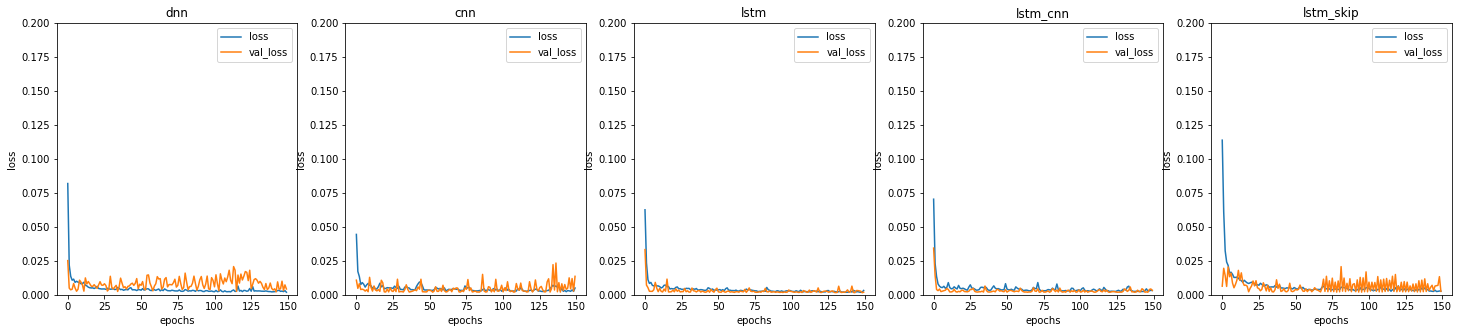

In [50]:
legend = list()

fig, axs = plt.subplots(1, 5, figsize=(25,5))

def plot_graphs(metric, val, ax, upper):
    ax.plot(val['history'].history[metric])
    ax.plot(val['history'].history[f'val_{metric}'])
    ax.set_title(key)
    ax.legend([metric, f"val_{metric}"])
    ax.set_xlabel('epochs')
    ax.set_ylabel(metric)
    ax.set_ylim([0, upper])
    
for (key, val), ax in zip(model_configs.items(), axs.flatten()):
    plot_graphs('loss', val, ax, 0.2)
print("Loss Curves")

MAE Curves


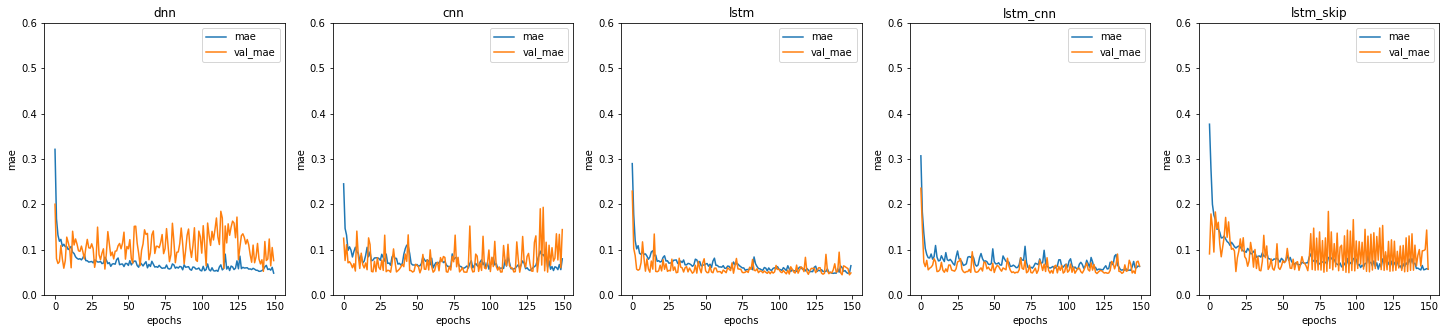

In [51]:
print("MAE Curves")
fig, axs = plt.subplots(1, 5, figsize=(25,5))
for (key, val), ax in zip(model_configs.items(), axs.flatten()):
    plot_graphs('mae', val, ax, 0.6)